In [1]:
#import packages that we'll use often.
import numpy as np
import math

#import plotting packages
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.colorbar as cb
%matplotlib inline

#set plotting defaults
from IPython.display import set_matplotlib_formats
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

In [2]:
#calculate dthetha/dt and domega/dt at a given point in time (ie, no stepping forward)
def PendulumDerivatives(theta, omega, time, g, l, q):
    dtheta = omega
    #note that this equation works only with a negative g value (ie, -9.8 vs. 9.8 as in caption
    #of Figure 3.6.  ALSO NOTE SIGN CHANGE IN ERRATA!)
    domega = (g/l)*np.sin(theta) - q*omega 
    return dtheta, domega

In [3]:
#make a compact way to set the parameters that will control our pendulum
def definePendulum(theta_0, omega_0, time_0, g, l, q, timeStep, FullTime):
    return theta_0, omega_0, time_0, g, l, q, timeStep, FullTime

In [4]:
#advance the Pendulum by a full RK4 timestep (which requires calculating derivatives at half timesteps)
def PendulumRK4Step(theta_i, omega_i, time_i, g, l, q, RK4timeStep, remap = False, theta_plot = False, omega_plot = False):
    
    #calculate half a time step. 
    half_step = RK4timeStep*0.5
    
    #calculate the derivatives here
    dtheta_for_k1, domega_for_k1 = PendulumDerivatives(theta_i, omega_i, time_i, g, l, q)
    #calculate k1 values -- IN THE FORMALISM WHERE K1 IS THE DELTA OF Y, NOT THE DERIVATIVE!!!
    k1_theta = dtheta_for_k1 * RK4timeStep
    k1_omega = domega_for_k1 * RK4timeStep


    #calculate the derivatives at y + k1_theta/2 and t + RK4timestep/2
    dtheta_for_k2, domega_for_k2 = PendulumDerivatives(theta_i+0.5*k1_theta, omega_i+0.5*k1_omega, time_i+half_step, g, l, q)
    #calculate k2 values -- IN THE FORMALISM WHERE K2 IS THE DELTA OF Y, NOT THE DERIVATIVE!!!
    k2_theta = dtheta_for_k2 * RK4timeStep
    k2_omega = domega_for_k2 * RK4timeStep     
        
    #calculate k3s
    dtheta_for_k3, domega_for_k3 = PendulumDerivatives(theta_i+0.5*k2_theta, omega_i+0.5*k2_omega, time_i+half_step, g, l, q)
    #calculate k3 values -- IN THE FORMALISM WHERE K3 IS THE DELTA OF Y, NOT THE DERIVATIVE!!!
    k3_theta = dtheta_for_k3 * RK4timeStep
    k3_omega = domega_for_k3 * RK4timeStep

    #calculate k4s
    dtheta_for_k4, domega_for_k4 = PendulumDerivatives(theta_i+k3_theta, omega_i+k3_omega, time_i+RK4timeStep, g, l, q)
    #calculate k4 values -- IN THE FORMALISM WHERE K1 IS THE DELTA OF Y, NOT THE DERIVATIVE!!!
    k4_theta = dtheta_for_k4 * RK4timeStep
    k4_omega = domega_for_k4 * RK4timeStep

    #now take the full step, using the weighted average of the k's we calculated above
    theta_full = theta_i + (k1_theta + 2*k2_theta + 2*k3_theta + k4_theta)/6.
    omega_full = omega_i + (k1_omega + 2*k2_omega + 2*k3_omega + k4_omega)/6.
    
    #now make the plot to illustrate what is going on (or try to, at least)
    if (theta_plot == True):
        #create numerical linear extrapolation of slope
        small_delta_ts = np.linspace(-0.1*RK4timeStep, 0.1*RK4timeStep, 40)
        full_delta_ts = np.linspace(-0.5*RK4timeStep, 0.5*RK4timeStep, 40)
        small_time_k1 = small_delta_ts + time_i
        theta_k1_slope = theta_i + small_time_k1 * dtheta_for_k1
        theta_k1_proj = theta_i + (0.5*RK4timeStep+full_delta_ts) * dtheta_for_k1

        plt.plot(full_delta_ts+0.5*RK4timeStep, theta_k1_proj, linewidth = 4, color = '0.8')
        K1, = plt.plot(small_time_k1, theta_k1_slope, linewidth = 4, color = 'red', label = 'K1')

        small_time_k2 = small_delta_ts + time_i 
        theta_k2_slope = theta_i + 0.5*k1_theta + small_time_k2 * dtheta_for_k2
        theta_k2_proj = theta_i+ 0.5*k1_theta + full_delta_ts * dtheta_for_k2

        plt.plot(full_delta_ts+0.5*RK4timeStep, theta_k2_proj, linewidth = 4, color = '0.8')
        K2, = plt.plot(small_time_k2+0.5*RK4timeStep, theta_k2_slope, linewidth = 4, color = 'green', label = 'K2')
        plt.xlim(-0.1*RK4timeStep, 1.1*RK4timeStep)
        
        theta_k3_slope = theta_i+ 0.5*k2_theta + small_time_k2 * dtheta_for_k3
        theta_k3_proj = theta_i + 0.5*k2_theta + full_delta_ts * dtheta_for_k3

        plt.plot(full_delta_ts+0.5*RK4timeStep, theta_k3_proj, linewidth = 4, color = '0.8')
        K3, = plt.plot(small_time_k2+0.5*RK4timeStep, theta_k3_slope, linewidth = 4, color = 'blue', label = 'K3')
        
        small_time_k4 = small_delta_ts + time_i 
        theta_k4_slope = theta_i+ k3_theta+ small_time_k4 * dtheta_for_k4
        theta_k4_proj = theta_i+ k3_theta + (-0.5*RK4timeStep+full_delta_ts) * dtheta_for_k4

        plt.plot(full_delta_ts+0.5*RK4timeStep, theta_k4_proj, linewidth = 4, color = '0.8')
        K4, = plt.plot(small_time_k4+RK4timeStep, theta_k4_slope, linewidth = 4, color = 'magenta', label = 'K4')
   
        #Repeat colored lines that may be obscured by gray ones
        K3, = plt.plot(small_time_k2+0.5*RK4timeStep, theta_k3_slope, linewidth = 4, color = 'blue', label = 'K3')
        K2, = plt.plot(small_time_k2+0.5*RK4timeStep, theta_k2_slope, linewidth = 4, color = 'green', label = 'K2')
        K1, = plt.plot(small_time_k1, theta_k1_slope, linewidth = 4, color = 'red', label = 'K1')

        plt.legend(handles=[K1, K2, K3, K4], loc=3)

    if (omega_plot == True):
        #create numerical linear extrapolation of slope
        small_delta_ts = np.linspace(-0.1*RK4timeStep, 0.1*RK4timeStep, 40)
        full_delta_ts = np.linspace(-0.5*RK4timeStep, 0.5*RK4timeStep, 40)
        small_time_k1 = small_delta_ts + time_i
        omega_k1_slope = omega_i + small_time_k1 * domega_for_k1
        omega_k1_proj = omega_i + (0.5*RK4timeStep+full_delta_ts) * domega_for_k1

        plt.plot(full_delta_ts+0.5*RK4timeStep, omega_k1_proj, linewidth = 4, color = '0.8')
        K1, = plt.plot(small_time_k1, omega_k1_slope, linewidth = 4, color = 'red', label = 'K1')

        small_time_k2 = small_delta_ts + time_i 
        omega_k2_slope = omega_i + 0.5*k1_omega + small_time_k2 * domega_for_k2
        omega_k2_proj = omega_i + 0.5*k1_omega + full_delta_ts * domega_for_k2

        plt.plot(full_delta_ts+0.5*RK4timeStep, omega_k2_proj, linewidth = 4, color = '0.8')
        K2, = plt.plot(small_time_k2+0.5*RK4timeStep, omega_k2_slope, linewidth = 4, color = 'green', label = 'K2')
        plt.xlim(-0.1*RK4timeStep, 1.1*RK4timeStep)
        
        omega_k3_slope = omega_i + 0.5*k2_omega + small_time_k2 * domega_for_k3
        omega_k3_proj = omega_i + 0.5*k2_omega + full_delta_ts * domega_for_k3

        plt.plot(full_delta_ts+0.5*RK4timeStep, omega_k3_proj, linewidth = 4, color = '0.8')
        K3, = plt.plot(small_time_k2+0.5*RK4timeStep, omega_k3_slope, linewidth = 4, color = 'blue', label = 'K3')
        
        small_time_k4 = small_delta_ts + time_i 
        omega_k4_slope = omega_i + k3_omega + small_time_k4 * domega_for_k4
        omega_k4_proj = omega_i + k3_omega + (-0.5*RK4timeStep+full_delta_ts) * domega_for_k4

        plt.plot(full_delta_ts+0.5*RK4timeStep, omega_k4_proj, linewidth = 4, color = '0.8')
        K4, = plt.plot(small_time_k4+RK4timeStep, omega_k4_slope, linewidth = 4, color = 'magenta', label = 'K4')
        
        #Repeat colored lines that may be obscured by gray ones
        K1, = plt.plot(small_time_k1, omega_k1_slope, linewidth = 4, color = 'red', label = 'K1')
        K2, = plt.plot(small_time_k2+0.5*RK4timeStep, omega_k2_slope, linewidth = 4, color = 'green', label = 'K2')
        K3, = plt.plot(small_time_k2+0.5*RK4timeStep, omega_k3_slope, linewidth = 4, color = 'blue', label = 'K3')

        plt.legend(handles=[K1, K2, K3, K4], loc=3)
        
        print(theta_i, omega_i, time_i)    
        print(k1_theta, k2_theta, k3_theta, k4_theta)
        print(k1_omega, k2_omega, k3_omega, k4_omega)
        print(theta_full, omega_full, time_i + RK4timeStep)    
    
    return theta_full, omega_full, time_i + RK4timeStep

theta_mini: 19.932107908239626
theta_mega: 19.932003505556334


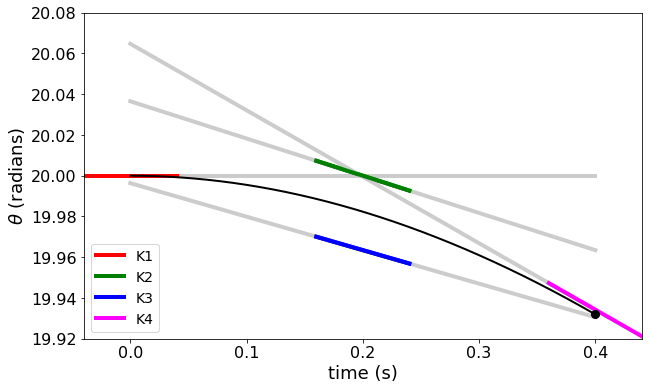

In [5]:
#define a position that we're interested in:
#initialize the pendulum as in Figure 3.6
theta_0 = 20.
omega_0 = 0
time_0 = 0
little_g = -9.8
pendulum_length = 9.8
q = 0.5
timeStep = 0.4

n_timeSteps = 1000
miniTimeStep = timeStep / n_timeSteps    
    
thetas = [theta_0]
omegas = [omega_0]
times = [time_0]
    
#loop through that many steps
for i in range(0,n_timeSteps-1):
    theta_next, omega_next, time_next = PendulumRK4Step(thetas[i], omegas[i], times[i], little_g, pendulum_length, q, miniTimeStep, remap = False, theta_plot = False)
    thetas = np.append(thetas, theta_next)
    omegas = np.append(omegas, omega_next)
    times = np.append(times, time_next)

print('theta_mini:', thetas[-1])
theta_next, omega_next, time_next = PendulumRK4Step(theta_0, omega_0, time_0, little_g, pendulum_length, q, timeStep, remap = False, theta_plot = True)
print('theta_mega:', theta_next)
plt.plot(time_next, theta_next, linewidth = 2, color = 'black', marker = 'o')
plt.plot(times, thetas, linewidth = 2, color = 'black', label = 'Full Trajectory')
plt.ylim(19.92,20.08)
ax = plt.gca()
surpressOutput = ax.get_yaxis().get_major_formatter().set_useOffset(False)
xlabel = plt.xlabel('time (s)') 
ylabel = plt.ylabel(r'$ \theta$ (radians)')

20.0 0 0
0.0 -0.07303562005821022 -0.0657320580523892 -0.130443610440792
-0.3651781002910511 -0.328660290261946 -0.32610902610198 -0.288445761356041
19.932003505556334 -0.32719374906249066 0.4


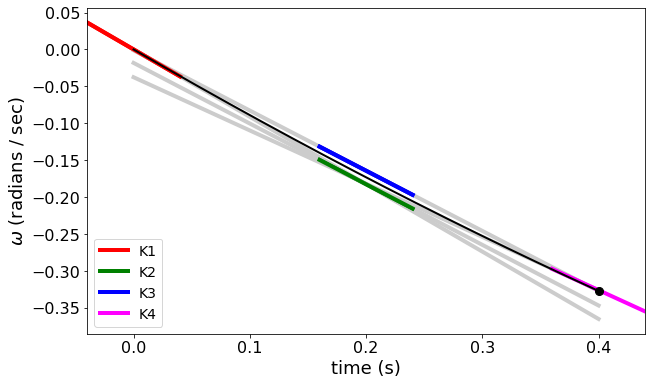

In [7]:
theta_next, omega_next, time_next = PendulumRK4Step(theta_0, omega_0, time_0, little_g, pendulum_length, q, timeStep, remap = False, omega_plot = True)
plt.plot(time_next, omega_next, linewidth = 2, color = 'black', marker = 'o')
plt.plot(times, omegas, linewidth = 2, color = 'black', label = 'Full Trajectory')
#plt.ylim(19.8,20.02)
ax = plt.gca()
surpressOutput = ax.get_yaxis().get_major_formatter().set_useOffset(False)
xlabel = plt.xlabel('time (s)') 
ylabel = plt.ylabel(r'$ \omega$ (radians / sec)')

